# practice for real magnetic data

### Contents

- [Optimisation routine](#Optimisation-routine)
- [Uncertainty analysis](#Uncertainty-analysis)
- [Sensitivity analysis](#Sensitivity-analysis)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [3]:
# parameters
nx, ny = 343, 268      # nodes of grid;
window_size = 100e3    # windows size;
x_distance=25e3        # x moving distance, or x resolution
y_distance=25e3        # y moving distance, or x resolution
input_filename="../../data/mag-kirgging.dat"  # input data; a txt, inverse from grid;
output_filename="../../data/zb_beta-prior-var-winodw.txt"   # result data file

In [4]:
# load x,y,anomaly
mag_data = np.loadtxt(input_filename)



x = mag_data[:,0]
y = mag_data[:,1]
# sometimes you need spesify a value when the spaceing is not idnetical.
nx=len(np.unique(x))   
ny=len(np.unique(y))
print(nx,ny)

343 268


In [5]:
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# initialise CurieOptimise object
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

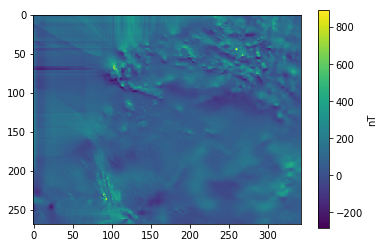

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
im1 = ax1.imshow(d)
fig.colorbar(im1, label='nT')

## Optimisation routine

Here we iteratively evaluate the Curie depth across the magnetic anomaly. We use gradient-based inversion which is deterministic, because it doesn't include uncertainty, but a quick means to recover Curie depth from the magnetic anomaly.

In [7]:
# get centroids


number of centroids = 432


In [8]:
# no priors
grid.reset_priors()
# set β
from scipy import stats
beta_p = stats.norm(3.0, 0.01)#定义一个正态分布，期望是 3，标准差是0.01
grid.add_prior(beta=beta_p)

beta, zt, dz, C = grid.optimise_routine(window_size, xc_list, yc_list)

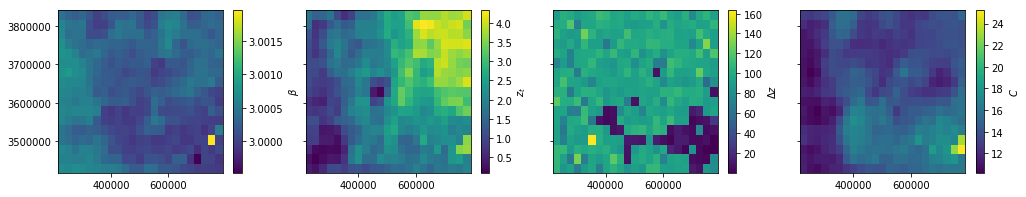

In [9]:
# get dimensions of domain
xcoords = np.unique(xc_list)
ycoords = np.unique(yc_list)
nc, nr = xcoords.size, ycoords.size


# plot results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(17,3.))

im1 = ax1.pcolor(xc_list.reshape(nr,nc), yc_list.reshape(nr,nc), beta.reshape(nr,nc))
im2 = ax2.pcolor(xc_list.reshape(nr,nc), yc_list.reshape(nr,nc), zt.reshape(nr,nc))
im3 = ax3.pcolor(xc_list.reshape(nr,nc), yc_list.reshape(nr,nc), dz.reshape(nr,nc))
im4 = ax4.pcolor(xc_list.reshape(nr,nc), yc_list.reshape(nr,nc), C.reshape(nr,nc))

fig.colorbar(im1, ax=ax1, label=r"$\beta$")
fig.colorbar(im2, ax=ax2, label=r"$z_t$")
fig.colorbar(im3, ax=ax3, label=r"$\Delta z$")
fig.colorbar(im4, ax=ax4, label=r"$C$")

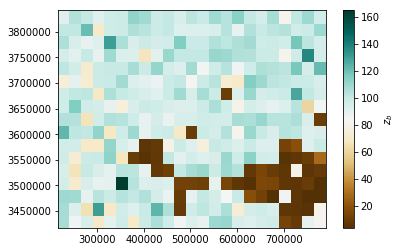

In [10]:
# plot Curie depth

curie_depth = zt + dz

fig = plt.figure()
ax1 = fig.add_subplot(111)
im1 = ax1.pcolor(xc_list.reshape(nr,nc), yc_list.reshape(nr,nc), curie_depth.reshape(nr,nc), cmap=plt.cm.BrBG)
fig.colorbar(im1, ax=ax1, label=r"$z_b$")

In [11]:
#合并三个数据组成数组
data=np.vstack(((xc_list, yc_list, curie_depth))).T
print(data.shape)

(432, 3)


In [12]:
np.savetxt(output_filename, data,fmt="%f")

## Uncertainty analysis

The variation of Curie depth is not particularly useful without any estimate of the uncertainty. We conduct the same MCMC simulation we performed in the previous example [Ex3-Posing-the-inverse-problem](./Ex3-Posing-the-inverse-problem.ipynb) to sample the posterior.

In [13]:
x_scale = [0.25, 0.1, 1.0, 0.5]

# run more simulations for production runs
burnin = 1000
nsim = 5000

# mean across the domain
mu_beta, mu_zt, mu_dz, mu_C = beta.mean(), zt.mean(), dz.mean(), C.mean()

pt_post = []

# This will take some time
for xc, yc in zip(xc_list, yc_list):
    posterior = grid.metropolis_hastings(window_size, xc, yc, nsim, burnin, x_scale,\
                                         mu_beta, mu_zt, mu_dz, mu_C, taper=None)
    pt_post.append( posterior )

In [14]:
curie_depth = np.zeros_like(xc_list)
uncertainty = np.zeros_like(xc_list)

for i, pt in enumerate(pt_post):
    betaP, ztP, dzP, CP = pt
    cpd = ztP + dzP
    curie_depth[i] = np.mean(cpd)
    uncertainty[i] = np.std(cpd)

Text(0.5,1,'Uncertainty (km)')

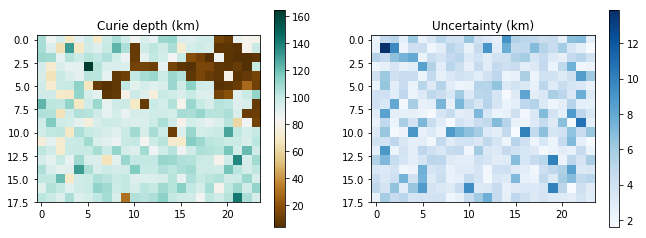

In [15]:
# plot Curie depth

curie_depth = zt + dz

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,4))
im1 = ax1.imshow(curie_depth.reshape(nr,nc), cmap=plt.cm.BrBG)
im2 = ax2.imshow(uncertainty.reshape(nr,nc), cmap=plt.cm.Blues)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

ax1.set_title("Curie depth (km)")
ax2.set_title("Uncertainty (km)")

## Sensitivity analysis

The sensitivity analysis is a gradient-based solution to approximate the posterior distribution (read the motivation for this in Tarantola: *Inverse Problem Theory*). The radial power spectrum $\Phi$ is randomly perturbed within its uncertainty $\sigma_{\Phi}$ to sample locally around the MAP estimate.

$$
\Phi_{d}^* = \Phi_d + \delta \Phi_d
$$

where $\delta \Phi_d$ is a random perturbation generated from the probability density of $\Phi_d$. This is equivalent to pertubing the likelihood function,

$$
P(\Phi|\mathbf{m}) = \frac{1}{(\sqrt{2\pi} \sigma_\Phi)^n} \exp \left( - \frac{\lvert \Phi(\mathbf{m}) - \Phi_d^* \lvert^2}{2 \sigma_\Phi^2} \right)
$$

where $\mathbf{m}^*$ is a perturbed prior distribution: $\mathbf{m}_p^* = \mathbf{m}_p + \delta \mathbf{m}_p$. If the prior is a Gaussian normal distribution, then the perturbed prior is

$$
P(\mathbf{m}) = \frac{1}{\sqrt{2\pi} \sigma_p} \exp \left( - \frac{\lvert \mathbf{m} - \mathbf{m}_p^* \lvert^2}{2 \sigma_p^2} \right)
$$

Prior distributions can be added by

```python
from scipy import stats
beta_p = stats.norm(3.0, 1.0)
grid.add_prior(beta=beta_p)
```

We repeat the inversion multiple times, sampling different values from $P(\mathbf{m})$ and $P(\Phi|\mathbf{m})$ to evaluate the uncertainty in each variable.

In [ ]:
nsim = 100
pt_post = []

for xc, yc in zip(xc_list, yc_list):
    sensitivity = grid.sensitivity(window_size, xc, yc, nsim, mu_beta, mu_zt, mu_dz, mu_C, taper=None)
    pt_post.append( sensitivity )

In [ ]:
curie_depth = np.zeros_like(xc_list)
uncertainty = np.zeros_like(xc_list)

for i, pt in enumerate(pt_post):
    betaP, ztP, dzP, CP = pt
    cpd = ztP + dzP
    curie_depth[i] = np.mean(cpd)
    uncertainty[i] = np.std(cpd)

In [ ]:
# plot Curie depth

curie_depth = zt + dz

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,4))
im1 = ax1.imshow(curie_depth.reshape(nr,nc), cmap=plt.cm.BrBG)
im2 = ax2.imshow(uncertainty.reshape(nr,nc), cmap=plt.cm.Blues)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

ax1.set_title("Curie depth (km)")
ax2.set_title("Uncertainty (km)")